# Image Classification using Bag of Visual Words

### Imports

In [ ]:
! pip uninstall opencv-python -y
! pip uninstall opencv-contrib-python -y
! pip install opencv-python==4.5.3.56
! pip install opencv-contrib-python==4.5.3.56

In [139]:
import os

import numpy as np
import cv2 as cv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skimage import io
from skimage import feature
from skimage import img_as_float
from skimage.transform import resize
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

### Utility Functions

In [54]:
def show(img):
    """
    Nothing to show
    """
    io.imshow(img, cmap='gray')
    plt.show()

In [53]:
def gallery(collection, labels=None, indices=None, nrows=1, ncols=3, k=6):
    """
    Display a random nrows x ncols gallery from collection.
    """
    if indices is None:
        indices = len(collection)

    rng = np.random.default_rng()

    fig, ax = plt.subplots(nrows, ncols, figsize=(k*nrows, k*ncols), squeeze=False)

    for r in range(nrows):
        for c in range(ncols):
            i = rng.choice(indices, replace=False)
            img = collection[i]
            ax[r][c].imshow(img, cmap='gray')
            if labels is not None:
                ax[r][c].set_title(labels[i])

    fig.tight_layout()
    plt.show()

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes=None, normalize=False, k=3):
    """
    Display confusion matrix as a heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    r, c = cm.shape

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    df = pd.DataFrame(cm)

    if classes:
        df.columns = classes
        df.index = classes

    fig, ax = plt.subplots(figsize=(k*r, k*c))
    ax = sns.heatmap(df, annot=True, cmap='YlGnBu')

    plt.show()

In [75]:
def load_images_from_folder(folder, shape):
    """
    Load all images from a folder and resize to 'shape'.
    """
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder,filename)

        img = cv.imread(path, flags=cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, shape, interpolation=cv.INTER_LINEAR)

        images.append(img)

    return np.array(images)

In [7]:
def load_data(main_dir, class_dirs, class_labels, shape, train=False):
    """
    Load images from a directory containing one folder for each class.
    """
    images = []
    labels = []

    for class_dir, class_label in zip(class_dirs, class_labels):
        path = main_dir + class_dir
        imgs = load_images_from_folder(path, shape)
        images.append(imgs)
        labels += [class_label] * len(imgs)

    images = np.vstack(images)
    labels = np.array(labels, dtype=object)
    
    if train:
        images, labels = shuffle(images, labels)

    return images, labels

### Load data

Objects dataset

In [124]:
TRAIN_DIR = './Objects_Dataset_Images/train/'
TEST_DIR = './Objects_Dataset_Images/test/'

CLASSES = ['Accordion', 'Dollar', 'Football' , 'Motorbike']
CLASS_DIRS = ['accordion/', 'dollar_bill/', 'Soccer_Ball/', 'motorbike/']

SHAPE = (256, 256)

In [125]:
train_images, train_labels = load_data(TRAIN_DIR, CLASS_DIRS, CLASSES, SHAPE, train=True)
print(train_images.shape)
print(train_labels.shape)

(56, 256, 256)
(56,)


In [106]:
test_images, test_labels = load_data(TEST_DIR, CLASS_DIRS, CLASSES, SHAPE, train=False)
print(test_images.shape)
print(test_labels.shape)

(8, 256, 256)
(8,)


Flowers dataset

In [133]:
MAIN_DIR = './flower_photos/'

CLASSES = ['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']
CLASS_DIRS = ['daisy/', 'dandelion/', 'roses/', 'sunflowers/', 'tulips/']

SHAPE = (256, 256)

TRAIN_FRACTION = 0.8

In [134]:
images, labels = load_data(MAIN_DIR, CLASS_DIRS, CLASSES, SHAPE, train=True)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size=TRAIN_FRACTION)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(2936, 256, 256)
(2936,)
(734, 256, 256)
(734,)


Dataset visualization

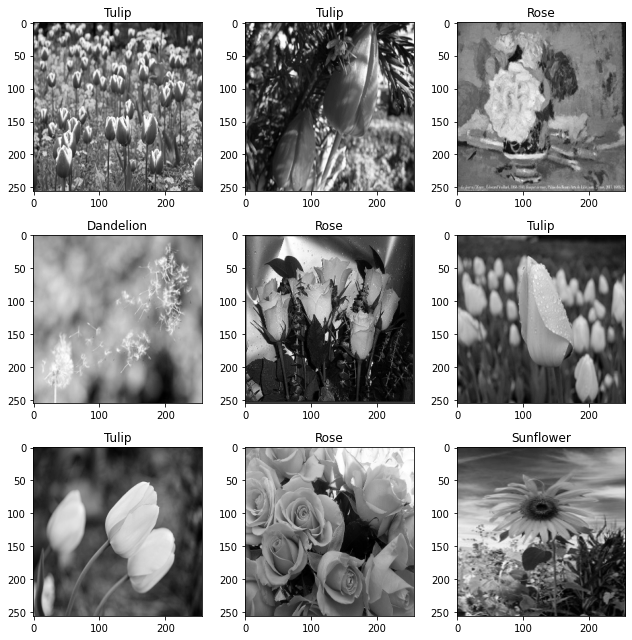

In [136]:
gallery(train_images, labels=train_labels, nrows=3, ncols=3, k=3)

### Bag of Visual Words

In [140]:
class BOVW:
    """
    Bag of Visual Words using SIFT descriptors and KMeans clustering.
        - fit() generates codebook
        - transform() converts images to histograms
    """
    def __init__(self, vocab_size, batch_size=64):
        self.vocab_size = vocab_size
        self.vocab = []
        self.sift = cv.SIFT_create()
        self.kmeans = MiniBatchKMeans(n_clusters=self.vocab_size, batch_size=batch_size)

    def fit(self, images):
        descriptors = self._get_descriptors(images)
        descriptors = np.vstack(descriptors)
        self.kmeans.fit(descriptors)
        self.vocab = self.kmeans.cluster_centers_

    def transform(self, images):
        descriptors = self._get_descriptors(images)

        histograms = []
        for des in descriptors:
            hgs = self._get_histogram(des)
            histograms.append(hgs)

        return np.array(histograms)

    def _get_descriptors(self, images):
        descriptors = []
        for img in images:
            kp, des = self.sift.detectAndCompute(img, None)
            descriptors.append(des)

        return descriptors

    def _get_histogram(self, des):
        words = self.kmeans.predict(des)
        hgs, _ = np.histogram(words, bins=self.vocab_size)

        return hgs

In [141]:
vocab_size = 10 * len(CLASSES)

fe = BOVW(vocab_size)
fe.fit(train_images)

BOVW feature visualization

Daisy


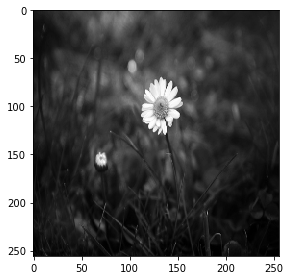

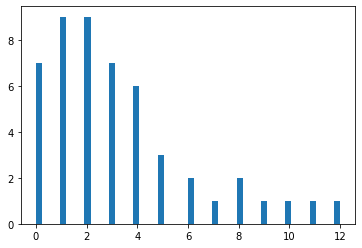

In [161]:
im = train_images[:1]
print(train_labels[0])
show(im[0])

hg = fe.transform(im)[0]
plt.hist(hg, bins=fe.vocab_size)
plt.show()

Prepare dataset for training

In [149]:
le = LabelEncoder()
le.fit(CLASSES)

LabelEncoder()

In [150]:
def preprocess(images, feature_extractor, labels, label_encoder):
    """
    Convert images and labels to features and class indices.
    """
    x = feature_extractor.transform(images)
    y = label_encoder.transform(labels)

    return x, y

In [151]:
x_train, y_train = preprocess(train_images, fe, train_labels, le)
print(x_train.shape)
print(y_train.shape)

(2936, 50)
(2936,)


### SVM Classification

In [152]:
clf = SVC()
clf.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Quantitative Evaluation

In [153]:
x_test, y_test = preprocess(test_images, fe, test_labels, le)
print(x_test.shape)
print(y_test.shape)

(734, 50)
(734,)


In [154]:
y_pred = clf.predict(x_test)
pred_labels = le.inverse_transform(y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.47      0.52       127
           1       0.60      0.77      0.67       175
           2       0.51      0.38      0.44       126
           3       0.60      0.61      0.61       132
           4       0.49      0.49      0.49       174

    accuracy                           0.56       734
   macro avg       0.55      0.55      0.54       734
weighted avg       0.55      0.56      0.55       734



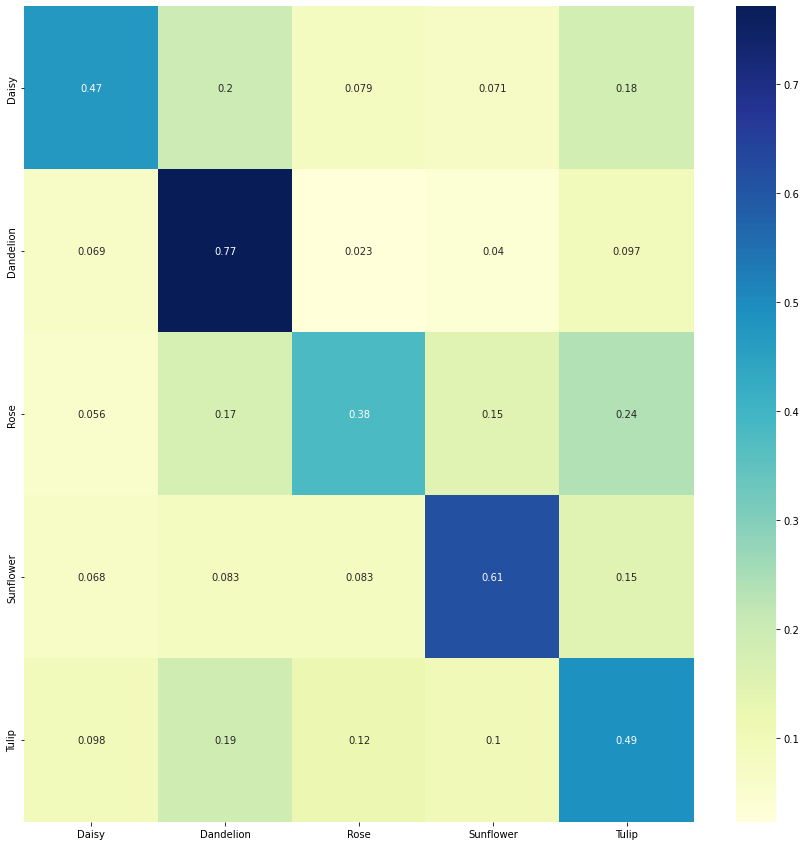

In [155]:
plot_confusion_matrix(y_test, y_pred, classes=CLASSES, normalize=True)

### Qualitative Evaluation

Correctly classified images and their predicted labels.

In [156]:
correct_indices = np.argwhere(y_test == y_pred).flatten()

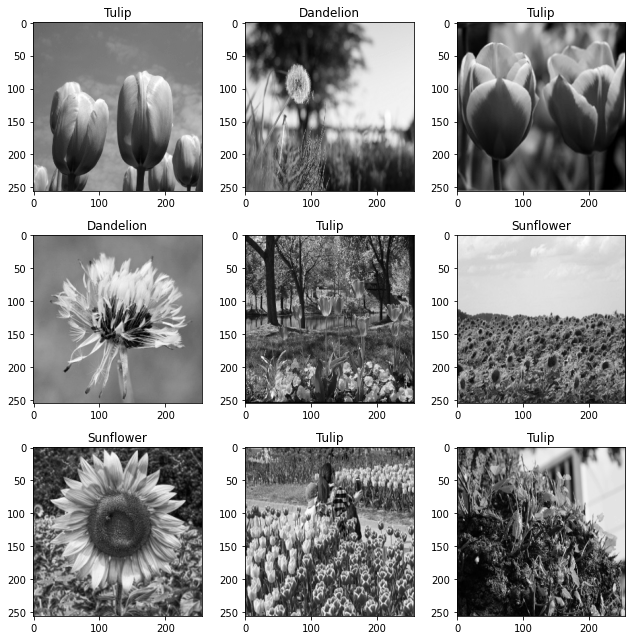

In [158]:
gallery(test_images, labels=pred_labels, indices=correct_indices, nrows=3, ncols=3, k=3)

Incorrectly classified images and their predicted labels.

In [159]:
wrong_indices = np.argwhere(y_test != y_pred).flatten()

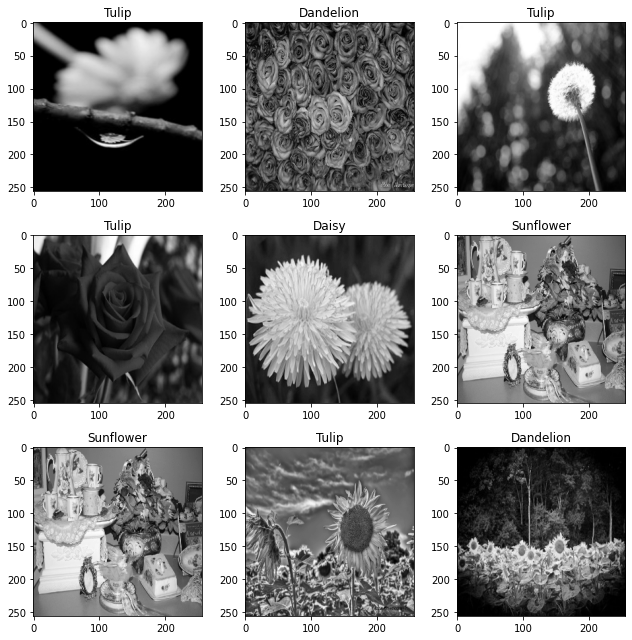

In [160]:
gallery(test_images, labels=pred_labels, indices=wrong_indices, nrows=3, ncols=3, k=3)